In [1]:
# Enable fullscreen

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [2]:
import numpy as np
from matplotlib import pyplot as pl
import os
import scipy.io.wavfile as wav

%matplotlib inline

In [3]:
PATH = './vowels/vowels/'

### file name format:
* n = natural
* s = synthetic
* a = adult
* m = male
* f = female



In [4]:
from python_speech_features import mfcc

## 1. Man vs Woman. Use only the natural voices of men and women to train a neural network that recognizes the gender of the speaker. 

180  elements have been read
nk7brii.wav [-1, -1, 1]
nafshoo.wav [1, -1, -1]
namshul.wav [-1, 1, -1]
nafkguh.wav [1, -1, -1]


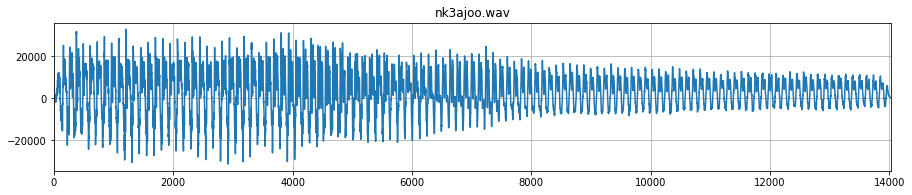

In [5]:
# Read all files starting with a pattern
def readFiles(pattern):
    sounds = []
    for file in os.scandir(PATH):
        if file.name.startswith(pattern):
            sample_rate, signal = wav.read(os.path.join(PATH, file.name))
            if file.name.startswith(pattern + 'af') :
                sound_class = [1,-1,-1]
            elif file.name.startswith(pattern + 'am'):
                sound_class = [-1,1,-1]
            else:
                sound_class = [-1,-1,1]
            sounds.append((sample_rate, signal, file.name, sound_class))
            
    print(len(sounds), ' elements have been read')
    return sounds

# Plot one sound (signal) with its pretty name
def plotSound(signal, name):
    pl.figure(figsize=(15,6))
    pl.subplot(2,1,1)
    pl.plot(signal)
    pl.xlim(0, len(signal))
    pl.title(name)
    pl.grid()

sounds = readFiles('n')

# Let's test if the read worked...
plotSound(sounds[0][1], sounds[0][2])

# Here we print the filename and the class. 
for sound in sounds[4:8]:
    print(sound[2], sound[3])

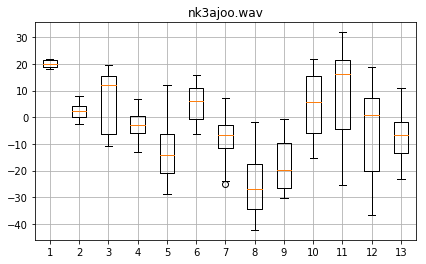

In [6]:
def doMFCC(signal, sample_rate):
    ceps = mfcc(signal, samplerate=sample_rate, nfft=1024)
    return ceps

def plotBoxSound(ceps, name):
    pl.figure(figsize=(15,4))
    pl.subplot(1,2,1)
    pl.boxplot(ceps)
    pl.title(name)
    pl.grid()
    
ceps_data = list(map(lambda s: doMFCC(s[1], s[0]) , sounds))

# List of all file names
ceps_names = list(map(lambda s: s[2] , sounds))

# List of all class
ceps_class = list(map(lambda s: s[3] , sounds))


# Some boxplot
plotBoxSound(ceps_data[0], ceps_names[0])

In [7]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
# We need this imports to normalize our data

In [8]:
# We noramlize the data
def feature(array):
    return min_max_scaler.fit_transform ( 
        list(map(lambda s: np.append( np.median(s, axis=0), np.std(s, axis=0).reshape(-1,1) ), array)),
    (-1,1))

normalized_ceps_data = feature(ceps_data)

In [9]:
print(len(normalized_ceps_data[0]))

26


In [10]:
dataset = np.hstack((np.array(normalized_ceps_data), np.array(ceps_class)))


## The MLP &  Cross-validation
Import the code of the backpropagation with momentum algorithm and the code of the cross-valdidation test

In [11]:
import mlp_backprop_momentum as mlp
import k_fold_cross_validation as cv

### Util functions

In [12]:
def split_dataset(dataset, n_parts=5):
    n_rows = dataset.shape[0]
    index_all = np.arange(n_rows)
    np.random.shuffle(index_all)
    parts = []
    current_start = 0
    for p in np.arange(n_parts):
        current_end = current_start + int(np.floor(n_rows / (n_parts-p)))
        parts.append(dataset[index_all[current_start:current_end],:])
        n_rows -= current_end - current_start
        current_start = current_end
    return parts

In [13]:
def k_fold_cross_validation(mlp, dataset, K=5, learning_rate=0.01, momentum=0.7, epochs=100):
    MSE_train_mean = 0.0
    MSE_test_mean = 0.0

    parts = split_dataset(dataset, K)
    
    for k in np.arange(K):
        mlp.init_weights()
        
        training_parts = set(np.arange(K))
        training_parts.remove(k)
        dataset_train = np.concatenate([parts[i] for i in list(training_parts)])
        dataset_test = parts[k]

        input_data = dataset_train[:,0:nn.n_inputs]
        output_data = dataset_train[:,nn.n_inputs:(nn.n_inputs+nn.n_outputs)]
        input_data_test = dataset_test[:,0:nn.n_inputs]
        output_data_test = dataset_test[:,nn.n_inputs:(nn.n_inputs+nn.n_outputs)]
        
        MSE_train = mlp.fit((input_data, output_data),
                            learning_rate=learning_rate, momentum=momentum, epochs=epochs)
        temp, _ = mlp.compute_MSE((input_data, output_data))
        MSE_train_mean += temp
        temp, _ = mlp.compute_MSE((input_data_test, output_data_test))
        MSE_test_mean += temp

    return (MSE_train_mean / K, MSE_test_mean / K)

## Experiment

### Configuration of the MLP

In [14]:
# Configuration

N_INITS = 10
EPOCHS = 200 # En gros, le nombre d'exécution
N_NEURONS = [4, 8, 12, 16, 20]
LEARNING_RATE = 0.01 # Pour la correction
MOMENTUM = 0.5# On pousse la boule avec de l'élan

N_FEATURES = 26
ACTIVATION_FUNCTION = 'tanh'

OUT= 3

In [15]:
def runMLP(LEARNING_RATE, MOMENTUM):
    MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))

    for i_h, h in enumerate(N_NEURONS):                                     # looping over the number of hidden neurons
        print('Testing', h, 'neurons...')
        nn = mlp.MLP([N_FEATURES,h,OUT], ACTIVATION_FUNCTION)
        for i in np.arange(N_INITS):                                        # looping over the initializations
            nn.init_weights()

            MSE[i_h, i, :] = nn.fit((dataset[:,0:26], dataset[:,26:27]),
                                    learning_rate=LEARNING_RATE,
                                    momentum=MOMENTUM,
                                    epochs=EPOCHS)
        
    print('Done :D')
    
    return MSE

In [16]:
def plotFigure(MSE):
    pl.figure(figsize=(15,4))
    p_count = 0
    for n in np.arange(MSE.shape[0]):
        pl.subplot(1, MSE.shape[0], n+1)
        for i in np.arange(MSE.shape[1]):
            pl.plot(MSE[n,i,:], c='b')
        pl.ylim(0,1)
        pl.xlabel('Epochs')
        pl.ylabel('MSE')
        pl.title(str(N_NEURONS[n]) + ' neurons')
        pl.grid()
    pl.tight_layout()

Testing 4 neurons...
Testing 8 neurons...
Testing 12 neurons...
Testing 16 neurons...
Testing 20 neurons...
Done :D


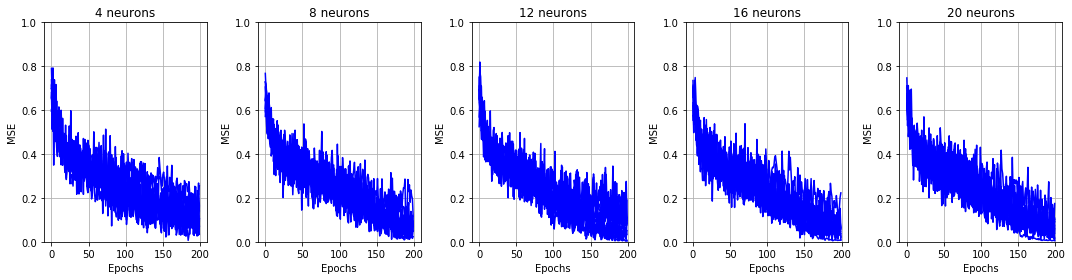

In [17]:
MSE = runMLP(0.01, 0.5)
plotFigure(MSE)

## Exploring the number of hidden neurons
Knowing that there are no significant improvements after 50 iterations, we can now further explore how the complexity of the model (number of hidden neurons) is linked to the generalization performance (test error). The following snippet allows you to explore both the number of epochs and the number of hidden neurons without restarting the training.

In [136]:
EPOCHS = 120
K = 5
N_TESTS = 10
LEARNING_RATE = 0.003 # Pour la correction
MOMENTUM = 0.6 
N_NEURONS = [4, 6, 8, 10, 15, 20, 25, 30, 35]

OUT=3

In [137]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([N_FEATURES,h,OUT], ACTIVATION_FUNCTION)
    for i in np.arange(N_TESTS):                                        # looping the tests
        nn.init_weights()                                               # the network has to be reinitialized before each test
        temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,         # notice that we do not use cv.k_fold_cross_validation
                                                            dataset,    # but cv.k_fold_cross_validation_per_epoch which
                                                            k=K,        # returns a value of error per each epoch
                                                            learning_rate=LEARNING_RATE,
                                                            momentum=MOMENTUM,
                                                            epochs=EPOCHS)
        # temp1 and temp2 are the training and test error. One value per epoch
        MSE_train[i_h, :, i] = temp1
        MSE_test[i_h, :, i] = temp2
        
print('Done')

Testing 2 neurons...
Testing 4 neurons...
Testing 6 neurons...
Testing 8 neurons...
Testing 10 neurons...
Testing 15 neurons...
Testing 20 neurons...
Testing 25 neurons...
Testing 30 neurons...
Done


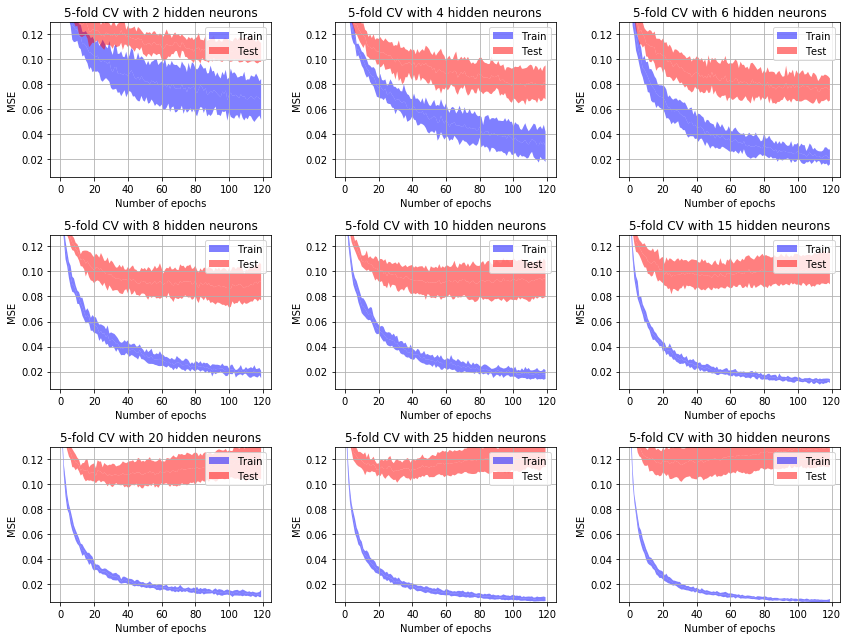

In [138]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min,0.5*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

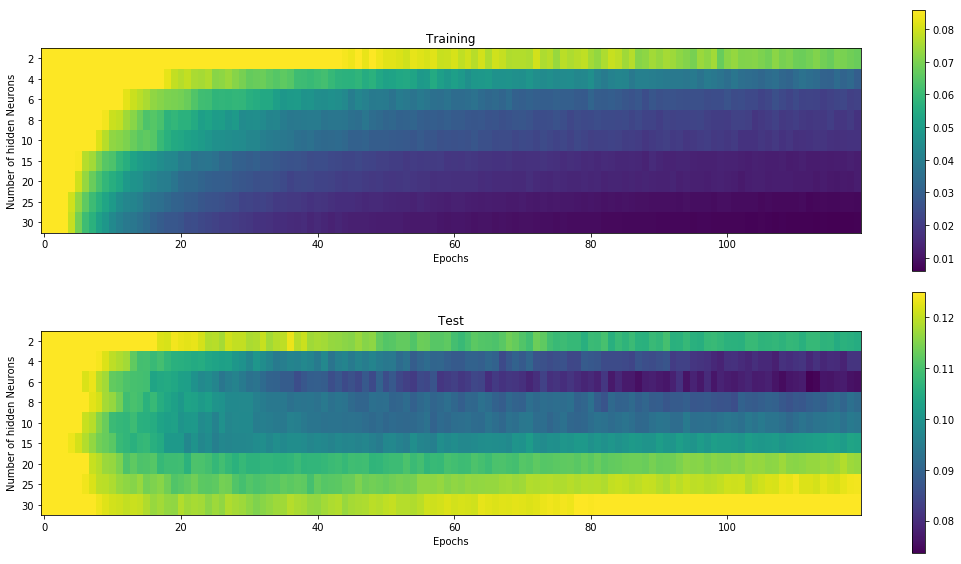

In [139]:
pl.figure(figsize=(15,8))
pl.subplot(2,1,1)
pl.imshow(MSE_train_mean, vmin=np.min(MSE_train_mean), vmax=np.percentile(MSE_train_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()
pl.subplot(2,1,2)
pl.imshow(MSE_test_mean, vmin=np.min(MSE_test_mean), vmax=np.percentile(MSE_test_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()
pl.tight_layout()

## The final model

An artificial neural network with 6 neurons and 60 iterations of the backpropagation algorithm is enough to solve the problem.

In [149]:
N_INITS = 10
EPOCHS = 150 # En gros, le nombre d'exécution
N_NEURONS = [2, 4, 8, 12, 16]
LEARNING_RATE = 0.01 # Pour la correction
MOMENTUM = 0.5 # On pousse la boule avec de l'élan


N_FEATURES = 26
ACTIVATION_FUNCTION = 'tanh'

OUT=3

h=6

nn = mlp.MLP([N_FEATURES,h,OUT], ACTIVATION_FUNCTION)

In [150]:
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                          dataset,
                                                          k=K,
                                                          learning_rate=LEARNING_RATE,
                                                          momentum=MOMENTUM,
                                                          epochs=EPOCHS,
                                                          threshold=0.0)

In [151]:
print('MSE training: ', MSE_train)
print('MSE test: ', MSE_test)
print('Confusion matrix:')
print(conf_mat)

MSE training:  0.03840359339318521
MSE test:  0.08615921060848962
Confusion matrix:
[[ 35.  31.  34.]
 [ 27.  36.  18.]
 [ 79.  26. 108.]]


### Confusion matrix:

TODO

Over 180 files read